<a href="https://colab.research.google.com/github/fwitschel/HCIBM/blob/main/notebooks/Explainable_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# Execute this code only if in colab
if 'COLAB_GPU' in os.environ:
  print("Executing in Colab!")
  # Cloning GitHub repository
  !git clone https://github.com/fwitschel/HCIBM.git
  %cd HCIBM


Executing in Colab!
fatal: destination path 'HCIBM' already exists and is not an empty directory.
/content/HCIBM


In [2]:
!pip install lime
!pip install imodels

import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular
from xgboost import XGBClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree
from imodels import RuleFitRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

import warnings
# Unterdrückt spezifisch Deprecation-Warnungen
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [39]:
# load the data
data = pd.read_csv('/content/HCIBM/datasets/Myocardial infarction complications Database.csv')

# remove the columns corresponding to other complications that we do not want to predict
data = data.drop('KFK_BLOOD', axis=1)
data = data.drop('IBS_NASL', axis=1)
data = data.drop('LET_IS', axis=1)
data = data.drop('P_IM_STEN', axis=1)
data = data.drop('REC_IM', axis=1)
data = data.drop('DRESSLER', axis=1)
data = data.drop('RAZRIV', axis=1)
data = data.drop('OTEK_LANC', axis=1)
data = data.drop('A_V_BLOK', axis=1)
data = data.drop('FIBR_JELUD', axis=1)
data = data.drop('JELUD_TAH', axis=1)
data = data.drop('PREDS_TAH', axis=1)
data = data.drop('FIBR_PREDS', axis=1)
data = data.drop('ID', axis=1)

# we additionally drop some columns where a lot of values are missing
# (makes performance of models better...)
data = data.drop('S_AD_KBRIG', axis=1)
data = data.drop('D_AD_KBRIG', axis=1)
data = data.drop('NOT_NA_KB', axis=1)
data = data.drop('LID_KB', axis=1)
data = data.drop('NA_KB', axis=1)
data = data.drop('GIPO_K', axis=1)

X = data.drop('ZSN', axis=1)
one_hot_X = pd.get_dummies(X)
y = data.ZSN

In [40]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y, test_size=0.2)
model = XGBClassifier(n_estimators = 42, max_depth = 5)

# A central problem with RuleFit is that it cannot deal with missing values - whereas XGBoost can...
# here, we will handle this by replacing missing values with a special constant
# -> you can check that it has very minor influence on performance...!
X_train_const = X_train.fillna(-999)
X_test_const = X_test.fillna(-999)
model.fit(X_train_const.values, y_train.values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=42,
              n_jobs=None, num_parallel_tree=None, ...)

In [41]:
# evaluate model quickly:
y_probs = model.predict_proba(X_test_const)[:, 1]
auc_score = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC score on test set: {auc_score:.4f}")

ROC-AUC score on test set: 0.7569


In [42]:
# let's use not the hard predictions (0 or 1), but the predicted probabilities
# note: this becomes a regression task now!!
y_sur = model.predict_proba(X_train_const)[:, 1]

In [44]:
if hasattr(X_train, "columns"):
  feature_names = list(X_train_const.columns)
else:
  feature_names = [f"x{i}" for i in range(X_train_const.shape[1])]

# 3. Training on predicted probabilities
# --- fit RuleFit surrogate ---
rf = RuleFitRegressor(
    n_estimators=35,          # number of trees used to generate candidate rules
    max_rules=300,       # cap on number of extracted rules
    tree_size=5,               # avg depth-ish; higher -> more complex rules
    random_state=42,
    include_linear=True,       # include linear terms too (we'll filter them later)
    exp_rand_tree_size=True,   # varied tree sizes helps rule diversity
)
rf.fit(X_train_const, y_sur, feature_names=feature_names)

# Optional quick sanity check of surrogate fidelity (on eval set if given)
if X_test is not None:
    y_xgb_pred = model.predict_proba(X_test_const)[:, 1]
    y_rf_pred = rf.predict(X_test_const.values).flatten()
    r2 = r2_score(y_xgb_pred, y_rf_pred)
    print(f"Fidelity: {r2:.4f}")

Fidelity: 0.6764


/tmp/ipython-input-1259042642.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


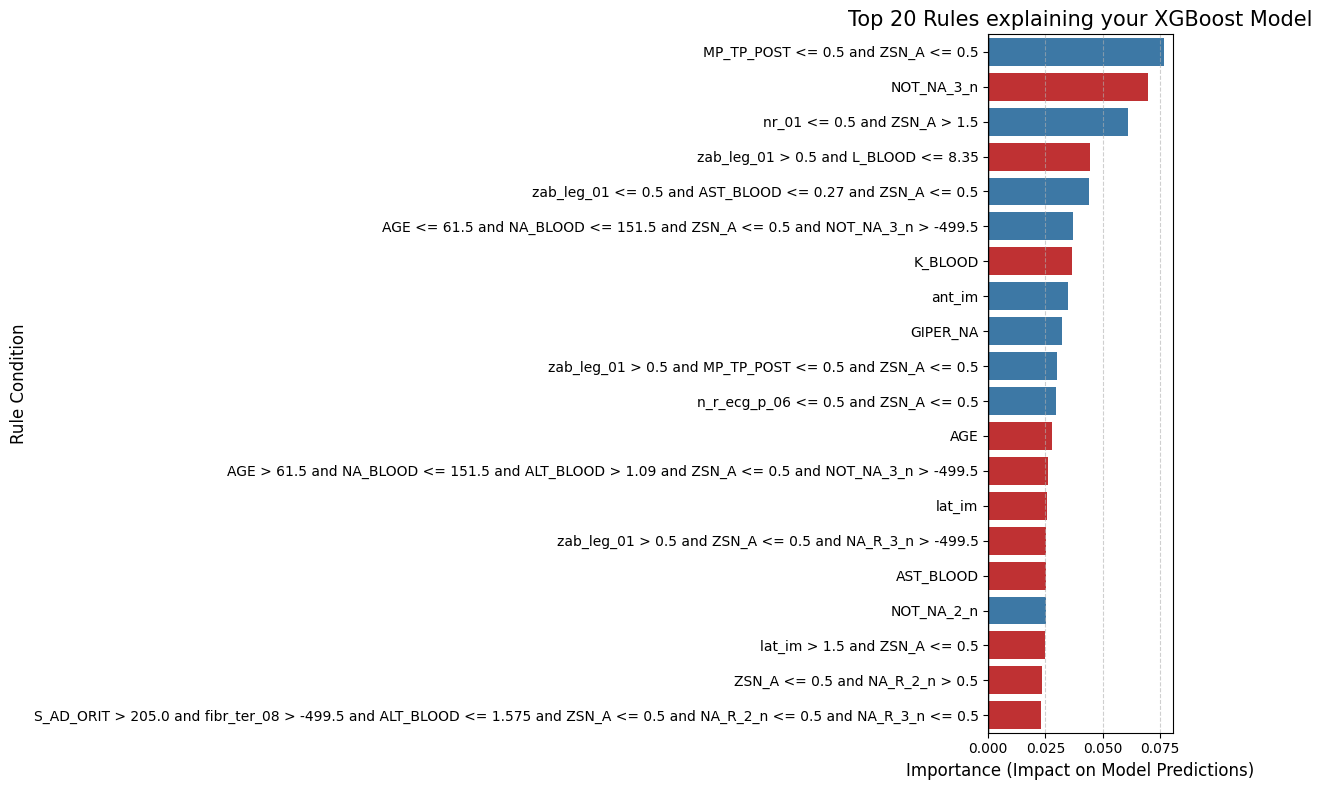

In [45]:
# --- extract and rank rules ---
df_rules = rf._get_rules()
df_plot = df_rules[df_rules.coef != 0].sort_values("importance", ascending=False).head(20)

# 3. Visualisation
plt.figure(figsize=(12, 8))

# Colors in our bar chart:
# red = rule increases predicted probability
# blue = rule decreases prediction
colors = ['#2c7bb6' if c < 0 else '#d7191c' for c in df_plot['coef']]

# note: importance is a mixture between the size of the coefficient and frequency of the rule
# where middle frequencies are considered most interesting
# \(I_{j}=|\^{a}_{j}|\cdot \sqrt{s_{j}\cdot (1-s_{j})}\)
# with a_j = coefficients and s_j = support values
sns.barplot(
    data=df_plot,
    x="importance",
    y="rule",
    palette=colors
)

plt.title("Top 20 Rules explaining your XGBoost Model", fontsize=15)
plt.xlabel("Importance (Impact on Model Predictions)", fontsize=12)
plt.ylabel("Rule Condition", fontsize=12)
plt.axvline(0, color='black', lw=1)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()